In [1]:
import numpy as np
import pandas as pd
import os, sys, json
import matplotlib.pyplot as plt

### Data Cleaning Workflow

1. **Read the Original Processor Dataset**:
    - The dataset contains various details about processors, including:
      - Product Type
      - Processor Name
      - Process Node
      - Die Area
      - TDP
      - GFLOPS
      - Release Date
      - Vendor
      - Manufacturing 
      - Frequency(GHz)

2. **Clean Up the Dataset**:
    - Remove unnecessary columns and keep only the relevant ones: *Processor Type, Name, Node, Die Area, TDP*

3. **Filter OutProcessors**:
    - Currently, **ECO-CHIP** and **CarbonSet** only supports monolithic chips, we partition the processors into *monolithic* and *chiplet* processors.
    - We further partition the GPUs and CPUs to separate datasets.

In [2]:
# Load the dataset
original_processors = pd.read_excel("DataSetWithRelaventNodesArea.xlsx")
# Define columns to drop
columns_to_drop = ['Freq (GHz)', 'Transistors (million)', 'Foundry']
# Identify and drop 'GFLOPS' columns dynamically
gflops_columns = [col for col in original_processors.columns if 'GFLOPS' in col]
columns_to_drop.extend(gflops_columns)
# Drop the specified columns
processors_cleaned = original_processors.drop(columns=columns_to_drop, errors='ignore')
# Replace 'unknown' and 0 values with NaN
processors_cleaned = processors_cleaned.replace({'unknown': np.nan, 0: np.nan})
# Ensure no silent downcasting issues occur
processors_cleaned = processors_cleaned.infer_objects(copy=False)
# Drop rows containing any NaN values
processors_cleaned = processors_cleaned.dropna()

/var/folders/m8/b_2080mx7_g7rw0h0twjfqk00000gn/T/ipykernel_78100/2227829289.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  processors_cleaned = processors_cleaned.replace({'unknown': np.nan, 0: np.nan})


In [3]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)
import utils
df_monolithic, df_chiplet = utils.separate_monolithic_and_chiplets(processors_cleaned)
processors_cleaned = pd.concat([df_chiplet, df_monolithic], ignore_index=True)

### Sustainable Metrics Generation for Cleaned Monolithic Chips

We can now further generate the sustainable metrics of cleaned monolithic chips in the following steps. Here we perform a **Monte-Carlo simulation** with a **Kernel Density Estimation** probabilistic model on every processor.

We have 5 semiconductor manufacturing parameters that significantly impact the overall carbon emission of processors, including:

- **Defective Density (dd)**: The ratio of actual fabricated faulty chips to functional chips, which is heavily depend on the *Process Node* applied. 
- **Gas per Area (gpa)**: The factor estimating the $CO_2$ emission per unit area.
- **Energy per Area (epa)**: The factor estimating the energy consumption per unit area. *Process Node* will also greatly impact this value.
- **Process Node (nm)**: The size of the process node in nanometers.
- **Carbon Intensity (ci)**: The sustainability estimation factor of the used energy/electricity source in terms of $CO_2$ emission per kWh.

We have detailed explanation and discussion of how the following probabilistic distribution is calculated / obtained in our paper. Please refer to the paper if any questions raised.  

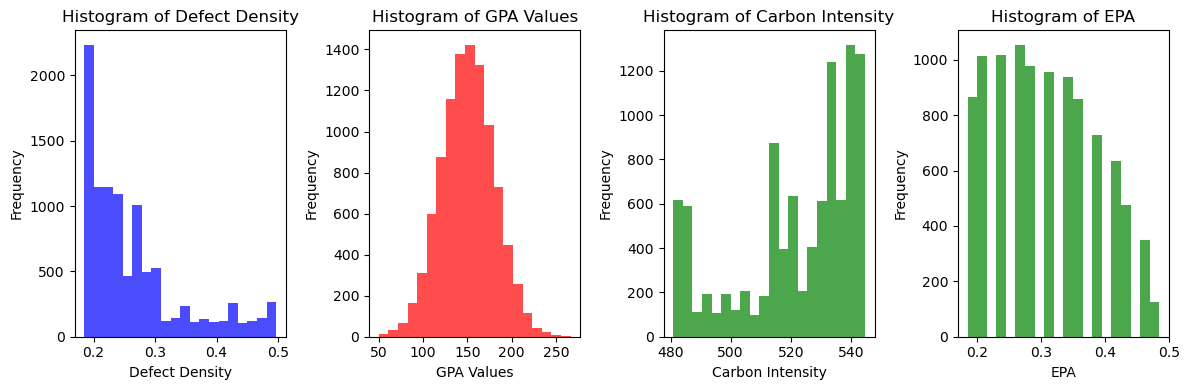

In [5]:
# lets plot the actual modeled distribution of all the parameters mentioned above with sample process node = 7nm
defective_density_sequence, epa_sequence, gpa_sequence, carbon_intensity_sequence = utils.generate_probabilistic_sequences()
node = '7'

plt.figure(figsize=(12, 4))

plt.subplot(1, 4, 1)
plt.hist(defective_density_sequence[node], bins=20, alpha=0.7, color='b')
plt.xlabel('Defect Density')
plt.ylabel('Frequency')
plt.title('Histogram of Defect Density')

# Plot histogram for gpa_sequence
plt.subplot(1, 4, 2)
plt.hist(gpa_sequence, bins=20, alpha=0.7, color='r')
plt.xlabel('GPA Values')
plt.ylabel('Frequency')
plt.title('Histogram of GPA Values')

# Plot histogram for ci_model
plt.subplot(1, 4, 3)
plt.hist(carbon_intensity_sequence, bins=20, alpha=0.7, color='g')
plt.xlabel('Carbon Intensity')
plt.ylabel('Frequency')
plt.title('Histogram of Carbon Intensity')


plt.subplot(1, 4, 4)
plt.hist(epa_sequence[node], bins=20, alpha=0.7, color='g')
plt.xlabel('EPA')
plt.ylabel('Frequency')
plt.title('Histogram of EPA')

plt.tight_layout()
plt.show()

### Carbon Footprint Calculation using ECO-CHIP
 
[ECO-CHIP](https://github.com/ASU-VDA-Lab/ECO-CHIP) is a chip carbon footprint modeling framework based on the chip interconnect, power, area, and above 4 parameters. 
**Key Assumptions and Operations in enhanced ECO-CHIP**

**Probabilistic Modeling**

- In here, we are applying previously generated probabilistic modeled 4 parameters into ECO-CHIP. Theoretically, every set of combinations of input parameters generate different CFP values. 
- Due to the inherent uncertainties of chip lifecycle, we are generating a wide range of CFP values instead of single CFP value. For every processor, we will calculate the minimum and maximum CFPs and eventually calculate the expected (mean) CFP value as the most representative CFP value of this processor. The min/max CFP can be directly derived using the min/max of input parameters.

**Chiplet & Monolithic Architecture Assumptions** 

- Every processor is treated as a combination of #dies and Average Die Area. Chiplet processors will have multiple dies, while monolithic chip will only have 1 die. 
1. All dies are manufactured using same process node. 
2. Total chip area is averaged out across each die. 
3. We only use RDL and 65nm process node for chiplet additional packaging. Extra area overhead is calculated within ECO-CHIP, area shown in the dataset/dataframe is the actual die area we obtained from official specs. Although the official specs should include the packaging overhead, the detailed specs of each die is not publicly available, so we still calculate the overhead in ECO-CHIP for simplicity.

**Parameters to ECO-CHIP**
- Original ECO-CHIP supports several input format specifying a chip architecture. Refer to ECO-CHIP github for details. 
- In our CarbonSet modeling, we are calculating some parameters on the fly, which means that the defect_density, epa, gpa, carbon intensity are not required input of original ECO-CHIP. 
- ECO-CHIP accepts .json and .txt specifications, which will overwrite the input chip area and other parameters. In our simulation and modeling, only those parameters in `arch_params/architecture.json` and `arch_params/node_list.txt` input processor dependent, which will be generated / overwritten as a scratch pad at runtime. All other parameters are the same as original ECO-CHIP.
- Several wrapper functions are created in `eco_chip_enhanced` to interact with original ECO-CHIP, feel free to modify it if want to adapt to your own projects.

In [6]:
import eco_chip_enhanced
import argparse


def get_cfp(process_node, power, area, defective_density, gpa, carbon_intensity, epa, epa_pack, defect_density_pack, dir = None, tech_path = None):

    # Calculate the Carbon Footprint (CFP) for the given processor
    args = argparse.Namespace(
        design_dir = dir,
        chip_area = area,
        chip_power = power,
        node = process_node,
        defect_density = defective_density,
        gpa = gpa, 
        epa = epa,
        epa_pack = epa_pack,
        defect_density_pack = defect_density_pack,
        num_lifetime=None,
        tech_scaling_path= tech_path,
        carbon_intensity = carbon_intensity
    )

    # we have design carbon, manufacturing carbon, operational carbon and total carbon
    design_carbon, mfg_carbon, ope_carbon, total_carbon = eco_chip_enhanced.eco_chip(args)
    embodied_carbon = float(design_carbon) + float(mfg_carbon)
    operational_carbon = float(ope_carbon)
    total_carbon = float(total_carbon)
    
    return embodied_carbon, operational_carbon, total_carbon

In [7]:
def calculate_min_max_cfp():
    for idx, proc in processors_cleaned.iterrows():
        node = int(proc['Process Size (nm)'])
        power = int(proc['TDP (W)'])
        area = int(proc['DieSizeValue'])
        file_path = '../eco_chip_enhanced/arch_params/'
        utils.generate_node_arch(proc['#dies'], node, proc['Avg Die Area'], file_path)        
        # calculate the minimum CFP values
        defective_density = defective_density_sequence[str(node)].min()
        epa = epa_sequence[str(node)].min()
        gpa = gpa_sequence.min()  
        carbon_intensity = carbon_intensity_sequence.min()     
        epa_pack = epa_sequence['65'].min()
        defective_density_pack = defective_density_sequence['65'].min()


        embodied_carbon_min, operational_carbon_min, total_carbon_min = get_cfp(node, power, area, defective_density, gpa, 
                                                                                carbon_intensity, epa, epa_pack=epa_pack,defect_density_pack=defective_density_pack)
        # update the cleaned processor dataframe
        processors_cleaned.at[idx, 'Emb_Carbon_Min'] = embodied_carbon_min
        processors_cleaned.at[idx, 'Ope_Carbon_Min'] = operational_carbon_min
        processors_cleaned.at[idx, 'Tot_Carbon_Min'] = total_carbon_min
        
        # calculate the maximum CFP values
        defective_density = defective_density_sequence[str(node)].max()
        epa = epa_sequence[str(node)].max()
        gpa = gpa_sequence.max()  
        carbon_intensity = carbon_intensity_sequence.max()     
        epa_pack = epa_sequence['65'].max()
        defective_density_pack = defective_density_sequence['65'].max()
        embodied_carbon_max, operational_carbon_max, total_carbon_max = get_cfp(node, power, area, defective_density, gpa, 
                                                                                carbon_intensity, epa, epa_pack=epa_pack, defect_density_pack=defective_density_pack)
        
        processors_cleaned.at[idx, 'Emb_Carbon_Max'] = embodied_carbon_max
        processors_cleaned.at[idx, 'Ope_Carbon_Max'] = operational_carbon_max
        processors_cleaned.at[idx, 'Tot_Carbon_Max'] = total_carbon_max

In [8]:
processors_cleaned

,Product,Type,Release Date,Process Size (nm),TDP (W),DieSizeValue,Die Size (mm^2),Vendor,#dies,Avg Die Area
0,AMD Ryzen Threadripper 1900X,CPU,2017-08-31,14.0,180.0,426.0,2x 213,AMD,2,213.0
1,AMD Ryzen Threadripper 1920X,CPU,2017-08-10,14.0,180.0,426.0,2x 213,AMD,2,213.0
2,AMD Ryzen Threadripper 1950X,CPU,2017-08-10,14.0,180.0,426.0,2x 213,AMD,2,213.0
3,AMD Ryzen 9 3900X,CPU,2019-07-07,7.0,105.0,148.0,2x 74,AMD,2,74.0
4,AMD Ryzen 9 3950X,CPU,2019-11-25,7.0,105.0,148.0,2x 74,AMD,2,74.0
...,...,...,...,...,...,...,...,...,...,...
1315,GTX TITAN Pascal,GPU,2016-01-01,14.0,250.0,471.0,471.0,NVIDIA,1,471.0
1316,GTX TITAN Xp,GPU,2017-01-01,14.0,250.0,471.0,471.0,NVIDIA,1,471.0
1317,GTX TITAN V,GPU,2018-01-01,14.0,250.0,815.0,815.0,NVIDIA,1,815.0
1318,RTX TITAN RTX,GPU,2018-12-01,14.0,280.0,754.0,754.0,NVIDIA,1,754.0


In [9]:
import time
start = time.time()

calculate_min_max_cfp()

end = time.time()
print(f"Min_Max CFP range calculation: running {end - start }s")

Min_Max CFP range calculation: running 8.842134714126587s


In [10]:
processors_cleaned

,Product,Type,Release Date,Process Size (nm),TDP (W),DieSizeValue,Die Size (mm^2),Vendor,#dies,Avg Die Area,Emb_Carbon_Min,Ope_Carbon_Min,Tot_Carbon_Min,Emb_Carbon_Max,Ope_Carbon_Max,Tot_Carbon_Max
0,AMD Ryzen Threadripper 1900X,CPU,2017-08-31,14.0,180.0,426.0,2x 213,AMD,2,213.0,5.646777,108.806635,114.453412,13.144774,123.242181,136.386955
1,AMD Ryzen Threadripper 1920X,CPU,2017-08-10,14.0,180.0,426.0,2x 213,AMD,2,213.0,5.646777,108.806635,114.453412,13.144774,123.242181,136.386955
2,AMD Ryzen Threadripper 1950X,CPU,2017-08-10,14.0,180.0,426.0,2x 213,AMD,2,213.0,5.646777,108.806635,114.453412,13.144774,123.242181,136.386955
3,AMD Ryzen 9 3900X,CPU,2019-07-07,7.0,105.0,148.0,2x 74,AMD,2,74.0,3.374873,76.877964,80.252837,5.051858,87.077483,92.129341
4,AMD Ryzen 9 3950X,CPU,2019-11-25,7.0,105.0,148.0,2x 74,AMD,2,74.0,3.374873,76.877964,80.252837,5.051858,87.077483,92.129341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,GTX TITAN Pascal,GPU,2016-01-01,14.0,250.0,471.0,471.0,NVIDIA,1,471.0,5.612041,151.120327,156.732368,26.735152,171.169696,197.904848
1316,GTX TITAN Xp,GPU,2017-01-01,14.0,250.0,471.0,471.0,NVIDIA,1,471.0,5.612041,151.120327,156.732368,26.735152,171.169696,197.904848
1317,GTX TITAN V,GPU,2018-01-01,14.0,250.0,815.0,815.0,NVIDIA,1,815.0,11.881005,151.120327,163.001332,127.786765,171.169696,298.956461
1318,RTX TITAN RTX,GPU,2018-12-01,14.0,280.0,754.0,754.0,NVIDIA,1,754.0,10.618779,169.254766,179.873545,99.229191,191.710059,290.939251


### Mean CFP Calculation

In this part, we will calculate the mean CFP value for every processor in our cleaned dataset, and this mean value will be used as the final CFP values of this processor. For each processor, we will calculate every possible CFP value using the combination of 4 input parameters with a size of *sample_size*. 

A good point of the *Monte-Carlo* simulation is that here, we only require *sample size* runs in total rather than *sample size^5*. Since all the input parameters are independent, iterating every permutation of these parameters has the exact same effect as just using the *sample_size* samples directly. 

Statistically speaking, every parameter sequence is generated randomly without any order. Therefore, directly combining them in a sequential manner to form a *sample_size* group of input parameters is exactly the same operation as iterating every permutation of the *sample_size^5* space. The final simulation result of the two methods will converge to a certain value with increased sample size.

**The overall runtime of mean CFP calculation will be significantly longer than the previous min/max CFP calculation. We highly suggest you follow the Monte-Carlo method we proposed here rather than using the conventional brute-force 'permutation' method, which usually takes hours to days based on our experiences.**

In [6]:
# this function will calculate the mean CFP value of every processor

def calculate_mean_cfp(idx, proc, sample_size = 100000):
    node = int(proc['Process Size (nm)'])
    power = int(proc['TDP (W)'])
    area = int(proc['DieSizeValue'])
    dest = f'../eco_chip_enhanced/mean_cfp/arch_params_{idx}/'
    src = f'../eco_chip_enhanced/arch_params/'
    utils.copy_design_operation_package(src=src, dest=dest)
    utils.generate_node_arch(proc['#dies'], node, proc['Avg Die Area'], dest)      

    embodied_carbon_list = np.zeros(sample_size)
    operational_carbon_list = np.zeros(sample_size)
    
    for i in range(sample_size):
        emb_c, ope_c, tot_c = get_cfp(node, power, area, defective_density_sequence[str(node)][i],
                                        gpa_sequence[i], carbon_intensity_sequence[i], epa_sequence[str(node)][i],
                                        defect_density_pack=defective_density_sequence['65'][i], epa_pack=epa_sequence['65'][i],
                                        dir=dest)
        embodied_carbon_list[i] = emb_c
        operational_carbon_list[i] = ope_c
        
    
    embodied_carbon_mean = embodied_carbon_list.mean()
    operational_carbon_mean = operational_carbon_list.mean()
    total_carbon_mean = embodied_carbon_mean + operational_carbon_mean
    
    return idx, embodied_carbon_mean, operational_carbon_mean, total_carbon_mean


In [12]:
processors_cleaned

,Product,Type,Release Date,Process Size (nm),TDP (W),DieSizeValue,Die Size (mm^2),Vendor,#dies,Avg Die Area,Emb_Carbon_Min,Ope_Carbon_Min,Tot_Carbon_Min,Emb_Carbon_Max,Ope_Carbon_Max,Tot_Carbon_Max
0,AMD Ryzen Threadripper 1900X,CPU,2017-08-31,14.0,180.0,426.0,2x 213,AMD,2,213.0,5.646777,108.806635,114.453412,13.144774,123.242181,136.386955
1,AMD Ryzen Threadripper 1920X,CPU,2017-08-10,14.0,180.0,426.0,2x 213,AMD,2,213.0,5.646777,108.806635,114.453412,13.144774,123.242181,136.386955
2,AMD Ryzen Threadripper 1950X,CPU,2017-08-10,14.0,180.0,426.0,2x 213,AMD,2,213.0,5.646777,108.806635,114.453412,13.144774,123.242181,136.386955
3,AMD Ryzen 9 3900X,CPU,2019-07-07,7.0,105.0,148.0,2x 74,AMD,2,74.0,3.374873,76.877964,80.252837,5.051858,87.077483,92.129341
4,AMD Ryzen 9 3950X,CPU,2019-11-25,7.0,105.0,148.0,2x 74,AMD,2,74.0,3.374873,76.877964,80.252837,5.051858,87.077483,92.129341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,GTX TITAN Pascal,GPU,2016-01-01,14.0,250.0,471.0,471.0,NVIDIA,1,471.0,5.612041,151.120327,156.732368,26.735152,171.169696,197.904848
1316,GTX TITAN Xp,GPU,2017-01-01,14.0,250.0,471.0,471.0,NVIDIA,1,471.0,5.612041,151.120327,156.732368,26.735152,171.169696,197.904848
1317,GTX TITAN V,GPU,2018-01-01,14.0,250.0,815.0,815.0,NVIDIA,1,815.0,11.881005,151.120327,163.001332,127.786765,171.169696,298.956461
1318,RTX TITAN RTX,GPU,2018-12-01,14.0,280.0,754.0,754.0,NVIDIA,1,754.0,10.618779,169.254766,179.873545,99.229191,191.710059,290.939251


In [13]:
import time, joblib

start = time.time()

results = joblib.Parallel(n_jobs=-1)(
    joblib.delayed(calculate_mean_cfp)(idx, proc) 
    for idx, proc in processors_cleaned.iterrows()
)
end = time.time()
print(f"Mean CFP Calculation running {end - start}s")


Mean CFP Calculation running 1063.737946510315s


In [14]:
for idx, emb_mean, ope_mean, tot_mean in results:
    processors_cleaned.at[idx, 'Emb_Carbon_Mean'] = emb_mean
    processors_cleaned.at[idx, 'Ope_Carbon_Mean'] = ope_mean
    processors_cleaned.at[idx, 'Tot_Carbon_Mean'] = tot_mean


In [15]:
processors_cleaned


,Product,Type,Release Date,Process Size (nm),TDP (W),DieSizeValue,Die Size (mm^2),Vendor,#dies,Avg Die Area,Emb_Carbon_Min,Ope_Carbon_Min,Tot_Carbon_Min,Emb_Carbon_Max,Ope_Carbon_Max,Tot_Carbon_Max,Emb_Carbon_Mean,Ope_Carbon_Mean,Tot_Carbon_Mean
0,AMD Ryzen Threadripper 1900X,CPU,2017-08-31,14.0,180.0,426.0,2x 213,AMD,2,213.0,5.646777,108.806635,114.453412,13.144774,123.242181,136.386955,7.739988,117.923893,125.663881
1,AMD Ryzen Threadripper 1920X,CPU,2017-08-10,14.0,180.0,426.0,2x 213,AMD,2,213.0,5.646777,108.806635,114.453412,13.144774,123.242181,136.386955,7.739988,117.923893,125.663881
2,AMD Ryzen Threadripper 1950X,CPU,2017-08-10,14.0,180.0,426.0,2x 213,AMD,2,213.0,5.646777,108.806635,114.453412,13.144774,123.242181,136.386955,7.739988,117.923893,125.663881
3,AMD Ryzen 9 3900X,CPU,2019-07-07,7.0,105.0,148.0,2x 74,AMD,2,74.0,3.374873,76.877964,80.252837,5.051858,87.077483,92.129341,4.029415,83.319816,87.349231
4,AMD Ryzen 9 3950X,CPU,2019-11-25,7.0,105.0,148.0,2x 74,AMD,2,74.0,3.374873,76.877964,80.252837,5.051858,87.077483,92.129341,4.029415,83.319816,87.349231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,GTX TITAN Pascal,GPU,2016-01-01,14.0,250.0,471.0,471.0,NVIDIA,1,471.0,5.612041,151.120327,156.732368,26.735152,171.169696,197.904848,9.481476,163.783185,173.264661
1316,GTX TITAN Xp,GPU,2017-01-01,14.0,250.0,471.0,471.0,NVIDIA,1,471.0,5.612041,151.120327,156.732368,26.735152,171.169696,197.904848,9.481476,163.783185,173.264661
1317,GTX TITAN V,GPU,2018-01-01,14.0,250.0,815.0,815.0,NVIDIA,1,815.0,11.881005,151.120327,163.001332,127.786765,171.169696,298.956461,27.314272,163.783185,191.097457
1318,RTX TITAN RTX,GPU,2018-12-01,14.0,280.0,754.0,754.0,NVIDIA,1,754.0,10.618779,169.254766,179.873545,99.229191,191.710059,290.939251,23.012306,183.437167,206.449473


In [16]:
processors_cleaned.to_csv("CarbonSet.csv", index=False)